In [1]:
%matplotlib inline 
import torch 
import torch.nn as nn
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt

from pyvi.utils import GMMLossFunc as lf
from pyvi.utils import HelperFunc as hf


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

print(f"Using {device} device")

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


# Nicholson's blowfly model

\begin{align*}
    n_t &= \begin{cases} r_t + s_t, \quad t \geq \tau \\ s_t, \quad t < \tau \end{cases};\qquad &\leftarrow \text{ population size}\\
    r_t &\sim \mathrm{Pois}\left(P n_{t-\tau} e^{-n_{t-\tau}/n_0} e_t\right) \qquad &\leftarrow \text{ delayed recruitment rate}\\
    s_t &\sim \mathrm{Binom}\left(e^{-\delta \epsilon_t}, n_{t-1} \right) \qquad &\leftarrow \text{ adult survival process}\\
    e_t &\sim \Gamma\left(\frac{1}{\sigma_p^2}, \frac{1}{\sigma_p^2} \right) \\ 
    \epsilon_t &\sim \Gamma\left(\frac{1}{\sigma_d^2}, \frac{1}{\sigma_d^2} \right)
\end{align*}

## Priors

\begin{align*}
    \delta &\sim \mathrm{Unif}(0.09, 0.4)\\
    P &\sim \mathrm{Unif}(3, 12)\\
    n_0 &\sim \mathrm{Unif}(150, 800)\\
    \tau &\sim \mathrm{Unif}(5, 25)\\
    \sigma_p^2 &\sim \mathrm{Unif}(0.01, 1)\\
    \sigma_d^2 &\sim \mathrm{Unif}(0.01, 1)\\
\end{align*}



### 1. Simulator

In [44]:
# simulator
def blowfly_model(theta: torch.Tensor, T=100) -> torch.Tensor:
    '''
    Simulates from the stochastic Nicholson's blowfly model
    '''
    delta, P, n0, tau, sigma2_p, sigma2_d = [theta[...,k] for k in range(theta.size(-1))]
    tau = tau.to(torch.int)
    # initialize 
    n = torch.zeros((len(n0), T+1))
    n[...,0] = n0

    # simulate demographic noises
    e = D.Gamma(1/sigma2_p, 1/sigma2_p).sample((T+1,)).T
    eps = D.Gamma(1/sigma2_d, 1/sigma2_d).sample((T+1,)).T

    # t < tau
    for t in range(1, T+1):
        # s[t]
        st =  D.Binomial(n[...,t-1], probs=torch.exp(- delta * eps[...,t])).sample()
        # r[t]
        if t >= tau:
            rt = D.Poisson(P * n[...,t - tau] * torch.exp(- n[...,t - tau] / n0) * e[...,t]).sample()
        else:
            rt = torch.zeros_like(st)
        # n[t]
        #print(st.shape)
        n[...,t] = rt + st

    return n

### 2. Priors

In [63]:
def prior(shape: torch.Size = ()):
        '''
        generate parameter vectors from the specified prior 
        '''
        theta = torch.stack([D.Uniform(low=0.09, high=0.4).sample(shape),     # delta
                             D.Uniform(low=3, high=12).sample(shape),         # P
                             torch.randint(low=150, high=800, size=shape),    # n0
                             torch.randint(low=5, high=25, size=shape),       # tau
                             D.Uniform(low=0.01, high=1).sample(shape),       # sigma2_p
                             D.Uniform(low=0.01, high=1).sample(shape)        # sigma2_d
                            ], dim=-1)       
        
        return theta
        
    

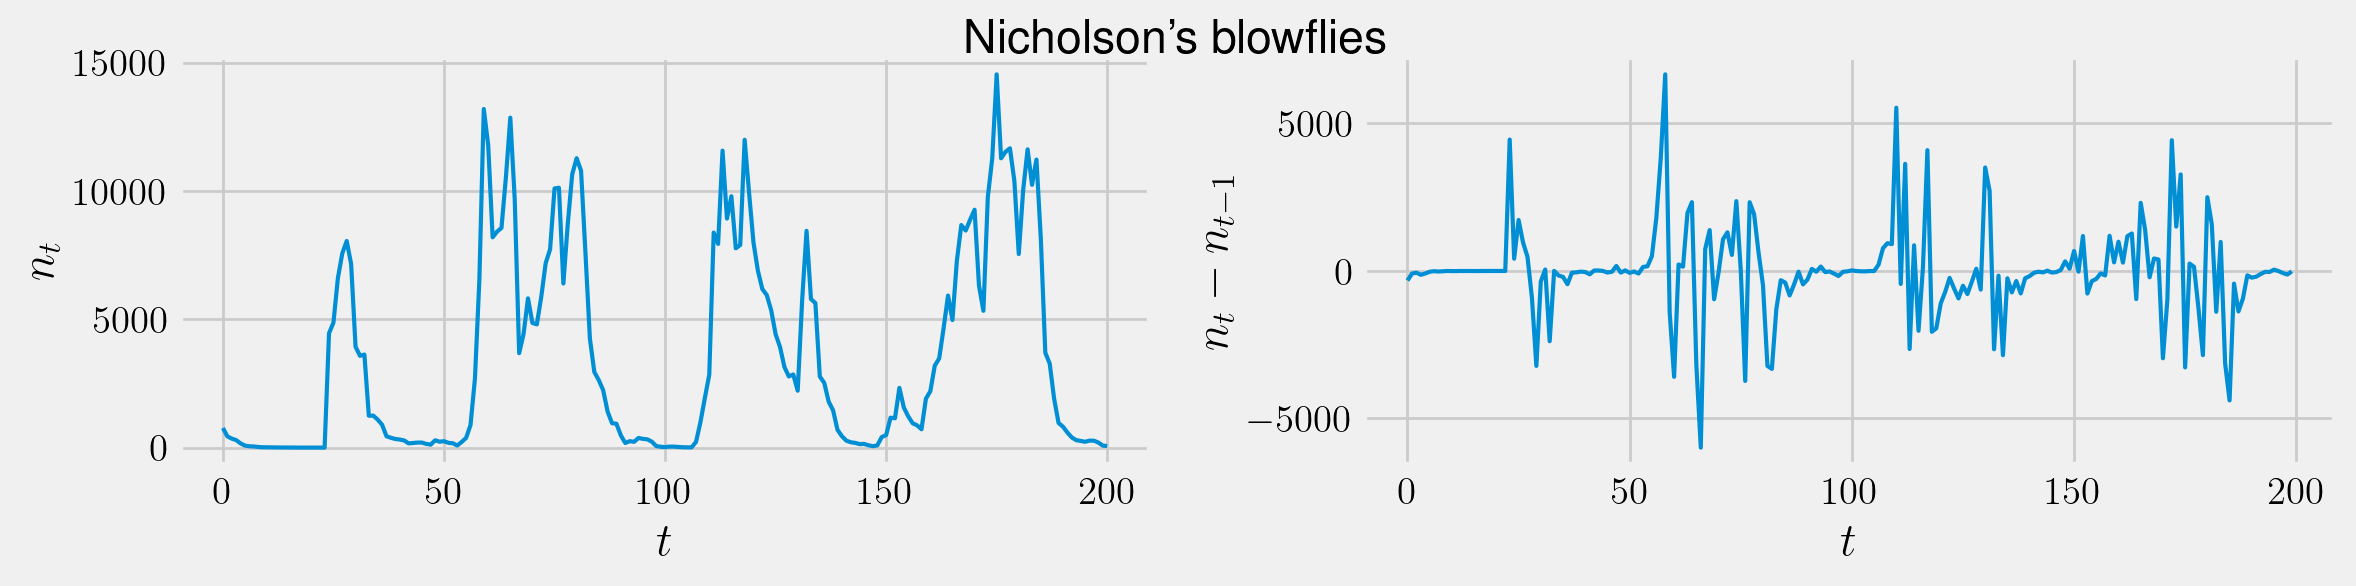

In [64]:
# model 
theta = prior((1,))
#theta = torch.tensor([[0.16, 6.5, 400, 14, 0.1, 0.1]])
T = 200

n = blowfly_model(theta, T).squeeze()

fig = plt.figure(figsize=(12,3), dpi=200)

fig.add_subplot(121)
plt.plot(n, lw=1.5)
plt.xlabel(r'$t$')
plt.ylabel(r'$n_t$')

fig.add_subplot(122)
plt.plot(n[1:] - n[:-1], lw=1.5)
plt.xlabel(r'$t$')
plt.ylabel(r'$n_t - n_{t-1}$')

plt.tight_layout()
plt.suptitle("Nicholson's blowflies")
plt.show()

### 3. Neural Varitional inference: Training the Neural Net

In [65]:
class LSTMNet(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64, num_hd=1):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 

        # lstm layer
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=120, num_layers=num_hd, batch_first=True)

        # fully connected hidden layer
        self.fc = nn.Sequential(
            nn.Linear(120, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):
        # lstm & hidden layers
        x, _ = self.lstm(x)
        x = x[:,-1,:]   # extract final time step
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
    

def transform_data(data, period_length, stride=None):
    if not stride:
        stride = period_length

    dataset = data.clone()

    dataset = dataset[...,1:] - dataset[...,:-1]
    dataset = dataset.sort(dim=-1).values
    
    Y = []

    stop = False
    i = 0
    while not stop:
        period = dataset[...,i:(i + period_length)]
        Y.append(period)
        i += stride

        stop = (dataset.size(1) < (i + period_length))
    
    # for i in range(dataset.size(1) // period_length):
    #     period = dataset[...,i*period_length:(i*period_length + period_length)]
    #     Y.append(period)
    
    return torch.stack(Y, dim=1)
        

### Training

In [ ]:
#Explicitly provided seeds for training process
random_seed = 1234
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, period_length, stride, batchsize = 10000, 101, 20, 3, 200

# sample parameter values from the specified prior
Theta_train =  prior.sample((n_prior,))

# draw samples from the simulator conditioned on parameter values
Y_train = blowfly_model(Theta_train, n_obs)
Y_train = transform_data(Y_train, period_length=period_length)
